# Homework 3 (Due Oct. 18)

## 1. The occasionally dishonest casino

Imagine that you are employed by the Montana State Gaming Board, and you have received an anonymous tip suggesting that the dealer in the dice games that frequently occur at the Oxford is cheating.  In particular, the dealer is surreptitiously switching from a fair die to a loaded one (and back) with a certain probability.  In this game, the ante is a doller.  you choose a number, the dealer rolls the die, and if it matches you get back 3 times your ante.  Otherwise, you lose your ante.  

You examine security camera footage from which you extracted the following dataset, with *states* describing whether the die was loaded, and rolls being the outcome of each die roll.

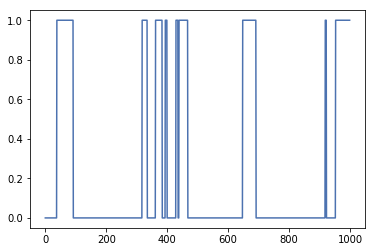

In [20]:
import pickle
import matplotlib.pyplot as plt

states,rolls = pickle.load(open('oxford.p','rb'))
plt.plot(states)
plt.show()

### 1a. Training a HMM (20pts)
Assume that the dealer follows a Markov model
$$
P(S_{t+1}=s_k|S_t=s_j) = A_{jk}, s_j\in\{0,1\},s_k\in\{0,1\},
$$
where $s_j=0$ corresponds to use of the fair die, while $s_j=1$ means the die is loaded.  The outcome of the die roll follows a categorical distribution conditioned on which die was being used
$$
P(R_t=r|S_t=s_j) = E_{jr}, r_t\in\{0,1,2,3,4,5\}.
$$
Note that for convenience, the dealer is using a six-sided, zero-indexed die.

Train your model of the dealer's ruse by using your observations to find the maximum likelihood estimators for the transition matrix $A$ and the emission probabilities $E$.  

HINT: because the states are observed, training $A$ is equivalent to training a normal Markov model.  Similarly, training $E$ is equivalant to training a Naive Bayes model, where the state is the class and the die roll is the feature.

In [21]:
import numpy as np
m = len(states)

A = np.zeros((2,2))
E = np.zeros((2,6))
#! Compute the parameters of the transition and emission matrices.


#**A: TRANSITION MATRIX** 

#first count number of times transitioned from one state to another
for i in range(m-1):
    A[states[i]][states[i+1]] += 1

statePriors = {
    0: A[0][0] + A[0][1],
    1: A[1][0] + A[1][1]
}

#normalize transition matrix
A[0][0] = A[0][0]/statePriors[0]
A[0][1] = A[0][1]/statePriors[0]
A[1][0] = A[1][0]/statePriors[1]
A[1][1] = A[1][1]/statePriors[1]

print(A)


#**E: EMISSION MATRIX (naive bayes)**   
for i in range(m):
    E[states[i]][rolls[i]] += 1

ones = states.sum()
zeros = m-ones

#normalize emission matrix
E[0,:]=E[0,:]/zeros   
E[1,:]=E[1,:]/ones
print(E)

[[0.98831169 0.01168831]
 [0.0349345  0.9650655 ]]
[[0.16623377 0.17792208 0.14155844 0.16883117 0.18701299 0.15844156]
 [0.0826087  0.06521739 0.12608696 0.09130435 0.11304348 0.52173913]]


### 1b. Determining when the house is cheating. (20pts)
Now that you know the cheating dealer's strategy, you decide that you want to catch the dealer in the act.  Play 1000 games of dice with the dealer, using the forward algorithm to determine when the dealer is cheating.  Recall that you now don't have access to the dealer's state, only the rolls!  Assume that the dealer starts using the fair die.  Report the probability that the dealer is using the loaded die at each of the 1000 rolls.

HINT: In the notation of Murphy, you are looking for $P(z_t=j|\mathbf{x}_{1:t})=\alpha_t(j)$, where $z_t=j\in\{0,1\}$ are the possible states and $\mathbf{x}_{1:t}$ are all the die rolls up to the current time.  The two step formula for computing this quantity can be found in Murphy Eqs. 17.44-17.47.


In [22]:
def likelihood(roll,state):
    return E[state,roll]

def prediction(state):
    return np.dot(state,A)

possible_states = [0,1]
possible_rolls = [0,1,2,3,4,5]

alpha = [np.array([1.0,0.0])]
current_state = 0
current_roll = np.random.choice(possible_rolls,p=E[0])

states = [current_state]
rolls = [current_roll]

for g in range(1000):
        
    ### This is the dealer's internal state, you can't use this information!
    current_state = np.random.choice(possible_states,p=A[current_state])
    states.append(current_state)
    ###
    
    ### This is the dealer's emission, you *can* use this information
    current_roll = np.random.choice(possible_rolls,p=E[current_state])
    rolls.append(current_roll)
    ###
    
    #! Implement the recursive forward algorithm to determine the probability 
    #! of being in the fair or loaded state for all rolls

#instantiate matrix
HMM = np.zeros((2, len(rolls)))
#fill in matrix for start w/ with fair dice
HMM[0][0] = 1 

#fill matrix
for i in range(1, len(rolls)):
    for j in [0,1]:
        HMM[j][i] = ((HMM[0][i-1] * A[j][0]) + (HMM[1][i-1] * A[j][1]))  * E[j][rolls[i]]

    # normalize
    denom = (HMM[0][i] + HMM[1][i])                                                                    
    HMM[0][i] = HMM[0][i]/denom 
    HMM[1][i] = HMM[1][i]/denom 
    

#predict state
statePrediction = []
for i in range(0, len(HMM[0])):
    if(HMM[1][i] > HMM[0][i]):
        statePrediction.append(1)
    else:
        statePrediction.append(0)

#calculate model accuracy
correct = 0
for i in range(0, len(states)):
    if(states[i] == statePrediction[i]):
        correct += 1
accuracy = correct / len(statePrediction)

print("Accuracy is: " + str(accuracy))
#print("Belief about the state at each roll:")

#print('ROLL   TRUTH           PREDICTION')
#for i in range(0, len(HMM[0])):
   # if(HMM[0][i] > HMM[1][i]):
   #     if(states[i] == 0):
   #         print(str(i)+"       Fair            Fair")
   #     elif(states[i] == 1):
   #         print(str(i)+"       Loaded          Fair")
   # else:
   #     if(states[i] == 0):
   #         print(str(i)+"       Fair            Loaded")
   #     elif(states[i] == 1):
   #         print(str(i)+"       Loaded          Loaded")
print("\nProbability dealer is using a loaded die for each roll:")
for i in range(0, len(HMM[0])):
    print(str(i)+ "   " + str(HMM[1][i]))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1.         0.97908043 0.95233071 ... 0.88816245 0.92716895 0.94291424]
 [0.         0.02091957 0.04766929 ... 0.11183755 0.07283105 0.05708576]]
Accuracy is: 0.8931068931068931

Probability dealer is using a loaded die for each roll:
0   0.0
1   0.020919566915540852
2   0.04766928678945687
3   0.04841806929407507
4   0.2186516641730881
5   0.21505161961643982
6   0.130453203606342
7   0.08274189280876999
8   0.06936143479336603
9   0.06129814946058778
10   0.035030093626991825
11   0.1889868897838662
12   0.4633207705889051
13   0.3198270313085426
14   0.15272721285749688
15   0.1581526340909267
16   0.11657664739550999
17   0.05668850217888013
18   0.04461097135690044
19   0.06721375685112976
20   0.03727197271101416
21   0.06114490748283712
22   0.046830301700456746
23   0.029620253221976464
24   0.03135144821711019
25   0.03218831355874303
26   0.18250799065915427
27   0.0847695422992227
28   0.07059133743002274
29   0.03855990583

### 1C (\*). Beating the house (10pts)
Describe a strategy for beating the house given all the information determined from the above two problems.  Show that your strategy will, in general, make money after 1000 rolls, either by mathematical proof, or by direct simulation. 

## 2. The Kalman Filter

### 2a.  Tracking in 2D.  (30pts)
Imagine that we are monitoring the position of an aircraft, moving according to a so-called *constant velocity* model, in which:
$$
x_{t+1} = x_t + \Delta t u_t + \frac{\Delta t^2}{2} a_x^2
$$
$$
y_{t+1} = y_t + \Delta t v_t + \frac{\Delta t^2}{2} a_y^2
$$
$$
u_{t+1} = u_t + \Delta t a_x
$$
$$
v_{t+1} = v_t + \Delta t a_y,
$$
where $x$ and $y$ are the spatial coordinates in the map-plane (measured in km), $u$ and $v$ are the corresponding velocities measured in (km/s), and $a_x$ and $a_y$ are random accelerations due to buffeting by winds that are independent from one another.  $\Delta t=0.1 \mathrm{s}$ is the measurement interval, and the time step involved in computing the evolution of the aircraft state.   

Defining $\mathbf{z}_t=[x_t,u_t,y_t,v_t]$, we can write this model as
$$
\mathbf{z}_{t+1} = \mathbf{A}_t \mathbf{z}_t + \mathbf{\epsilon}_t,
$$
where $A$ is a *state transition matrix* given by
$$
\mathbf{A}_t = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\
                    0 & 1 & 0 & 0  \\
                    0 & 0 & 1 & \Delta t \\
                    0 & 0 & 0 & 1 \end{bmatrix}.
$$

We assume that $\mathbf{\epsilon}_t = [\frac{\Delta t^2}{2} a_x^2, \Delta t a_x, \frac{\Delta t^2}{2} a_y^2, \Delta t a_y] \sim \mathcal{N}(0,\mathbf{Q}_t)$ is Gaussian noise with a zero mean, and $\mathbf{Q}_t$ is the covariance matrix
$$
\mathbf{Q}_t = a^2 \begin{bmatrix} 1/4 \Delta t^4 & 1/2\Delta t^3 & 0 &         0 \\
                        1/2 \Delta t^3 & \Delta t^2    & 0 &         0 \\
                        0 & 0 & 1/4 \Delta t^4 & 1/2\Delta t^3 \\
                        0 & 0 & 1/2 \Delta t^3 & \Delta t^2    \end{bmatrix},
$$
where $a=0.1 \mathrm{km/s}^2$ is a characteristic acceleration due to buffeting winds.

A global positioning unit fixed to the hull measures the coordinates $x$ and $y$.  At a fixed interval $\Delta t$ the unit returns an observation $\mathbf{y}_t = \mathbf{C}_t \mathbf{z}_t + \mathbf{\delta}_t$, where
$$
\mathbf{C}_t = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                    0 & 0 & 1 & 0 \end{bmatrix}
$$
is the observation matrix, mapping the state variables to observations (essentially picking out the positions and ignoring the velocities since these are not directly measured) and $\mathbf{\delta}_t \sim \mathcal{N}(0,\mathbf{R}_t)$ is Gaussian observation noise with $\mathbf{R}_t$ the observation covariance
$$
R_t = \begin{bmatrix} 0.05^2 & 0 \\
                           0 & 0.05^2 \end{bmatrix},
$$
indicating that positions are observed with a standard deviation of 0.05 km.

We seek the posterior probability distribution of states $P(\mathbf{z}_t|\mathbf{y}_{1:t}) = \mathcal{N}(\mu_t,\Sigma_t)$ having made measurements up to and including the current time.  This distribution combines our knowledge of the aircraft motion with our observations, both of which are imperfect due to randomness in the physical process (random winds) and in the observation process (measurement error).  The Kalman filter provides a recursive formula to find the distribution mean $\mu_t$ and covariance $\Sigma_t$.

Apply the Kalman filter to the aircraft motion and resulting observations simulated below.  After applying the filter, **generate a plot of the true aircraft positions, the observations, and the position estimates generated by filtering**.  **Report both the final and initial covariance matrices, and describe whether our state estimates are becoming more or less certain as filtering proceeds.**

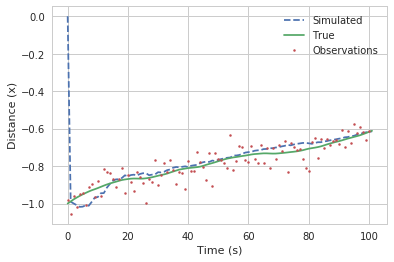

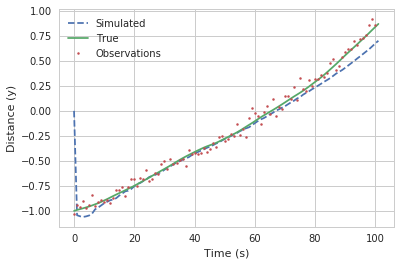

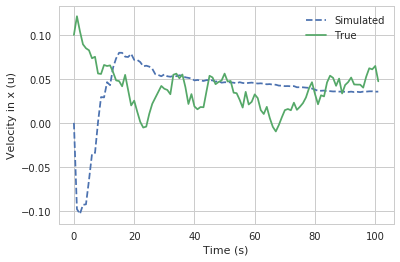

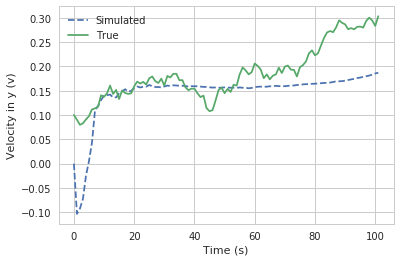

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Constants
a = 0.1   # Acceleration due to wind
dt = 0.1  # Interval for measurements

# Transition matrix
A = np.array([[1.0,dt,0.0,0.0],
              [0.0,1.0,0.0,0],
              [0.0,0.0,1.0,dt],
              [0.0,0.0,0,1.0]])

# Process noise covariance
Q = a**2*np.array([[1/4.*dt**4,1/2.*dt**3,         0,         0],
                   [1/2.*dt**3,     dt**2,         0,         0],
                   [         0,         0,1/4.*dt**4,1/2.*dt**3],
                   [         0,         0,1/2.*dt**3,     dt**2]])

Q += 1e-5*np.sum(np.diag(Q))*np.eye(4)

# Observation matrix
C = np.array([[1,0,0,0],
              [0,0,1,0]])

# Observation covariance
R = np.array([[0.05**2,0],
              [0,0.05**2]])

#print (Q)
### These are useful for sampling from normal distributions, but you
### don't need to worry about them.  
Q_cholesky = np.linalg.cholesky(Q)
R_cholesky = np.linalg.cholesky(R)
###
###


### The true state of the aircraft
### You do not have access to this information!
###
Z_true = [np.array([-1,0.1,-1,0.1])]
###
###
###

# Initial guess for aircraft position and velocity
mu_initial = np.array([0,0,0,0])

# Covariance matrix for this initial guess of position and velocity 
Sigma_initial = np.eye(4)*np.diag(np.array([1,1,1,1]))

# Lists for holding estimated states
mu = [mu_initial]
Sigma = [Sigma_initial]
Y = []


t=0
t_end = 10.0
while t<t_end:
    
    ### Simulate the motion of the aircraft
    ### You do not have access to this information!
    ### Don't change!
    Z_0 = Z_true[-1]                                            
    Z_1 = np.dot(A,Z_0) + np.dot(Q_cholesky,np.random.randn(4))  # Move the plane forward in time
    Z_true.append(Z_1)
    Y_1 = np.dot(C,Z_1) + np.dot(R_cholesky,np.random.randn(2))  # Take a noisy measurement
    Y.append(Y_1)
    ###
    ###
    ###
    
    mu_previous = mu[-1] # Best state mean estimate from last time step
    Sigma_previous = Sigma[-1] # state covariance from last time step
    Y_current = Y[-1]  # Current observation
    
    # Prediction step
    #! Write code to predict
    #print("A: ")
    #print(A)
    #print("mu previous: ")
    #print(mu_previous)
    mu_prior = np.dot(A,mu_previous) #! a) where the airplane will be according to the motion model
    Sigma_prior = np.dot(np.dot(A,Sigma_previous), A.T) + Q #! b) the covariance of that estimate
    
    # Update step
    #! Implement the formulae for the update step of the Kalman filter
    Kalman_gain_denominator = np.linalg.pinv(np.dot(np.dot(C,Sigma_prior),C.T) + R)
    Kalman_gain = np.dot(Sigma_prior, C.T)
    
    #! The posterior state mean estimate 
    mu_post = mu_prior + np.dot(Kalman_gain,(Y_current-np.dot(C,mu_prior)))
    #! The posterior covariance estimate
    Sigma_post =  np.dot((np.eye(4)-np.dot(Kalman_gain,C)),Sigma_prior)
    
    mu.append(mu_post)
    Sigma.append(Sigma_post)
    
    t+=dt
    
#! Plotting goes here.
#generate a plot of the true aircraft positions, the observations, 
#and the position estimates generated by filtering. 
#Report both the final and initial covariance matrices, and describe 
#whether our state estimates are becoming more or less certain as filtering proceeds.
plt.style.use('seaborn-deep')
import seaborn as sns
sns.set(style="whitegrid")

mu = np.array(mu)
#print(mu)
Z_true = np.array(Z_true)
#print(Z_true)
Y = np.array(Y)
#print(Y)

plt.plot(mu[:,0], '--', label='Simulated')
plt.plot(Z_true[:,0], label ='True')
plt.plot(Y[:,0], '.', label='Observations', markersize = 5)
ylabel('Distance (x)')
xlabel('Time (s)')
plt.legend()
plt.show()

plt.plot(mu[:,2], '--',label="Simulated")
plt.plot(Z_true[:,2], label="True")
plt.plot(Y[:,1], '.',label="Observations",markersize = 5)
plt.legend()
ylabel('Distance (y)')
xlabel('Time (s)')
plt.show()

plt.plot(mu[:,1], '--',label="Simulated")
plt.plot(Z_true[:,1], label="True")
plt.legend()
ylabel('Velocity in x (u)')
xlabel('Time (s)')
plt.show()

plt.plot(mu[:,3], '--',label="Simulated")
plt.plot(Z_true[:,3], label="True")
plt.legend()
ylabel('Velocity in y (v)')
xlabel('Time (s)')
plt.show()

In [102]:
print (' Initial covariance matrix \n -------------------------\n', Sigma[0])
print ('\n Final covariance matrix \n -----------------------\n', Sigma[-1])

 Initial covariance matrix 
 -------------------------
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

 Final covariance matrix 
 -----------------------
 [[0.04054496 0.00892596 0.         0.        ]
 [0.00892596 0.00420514 0.         0.        ]
 [0.         0.         0.04054496 0.00892596]
 [0.         0.         0.00892596 0.00420514]]


This shows the variances are decreasing as the simulation (posteriors) converges to the true values; confidence in the simulation is increasing with time. Interestingly, velocity (u and v) have high confidence, yet has more variation from the truth than distance. 

### 2b (\*) Extended Kalman Filter. (20pts)
The Kalman filter only applies to observation models that are linear.  However, this is a restrictive assumption.  Consider the case where instead of tracking the plane with a GPS, we are tracking it with a radar, where the radar provides an estimate of range ($\rho_t$) and angle ($\theta_t$).  Assuming that the radar is located at $(x=0,y=0)$, the process of taking an observation then is:
$$
\mathbf{y}_t = h(\mathbf{z}_t) + \mathbf{g}_t
$$
where $h(\mathbf{z}_t)$ is the transformation from Cartesian to Polar coordinates
$$ h(\mathbf{z}_t) = \left[ \rho_t(\mathbf{z}_t), \theta_t(\mathbf{z_t})\right] = \left[\sqrt{x_t^2 + y_t^2},\mathrm{arctan2}(y_t,x_t)\right]. $$

An extended Kalman filter works by linearizing the observation process, which is to say that every time we see the product $\mathbf{C}_t\mathbf{z_t}$ in the Kalman filter algorithm, we replace it with $h(\mathbf{z_t})$, and every time we see $\mathbf{C}_t$ on its own, we replace it with the **Jacobian matrix** $H_{jac}(\mathbf{z}_t)$, which is given by
$$
H_{jac}(\mathbf{z}_t) = \begin{bmatrix} \frac{\partial \rho_t}{\partial x_t} & \frac{\partial \rho_t}{\partial u_t} & \frac{\partial \rho_t}{\partial y_t} & \frac{\partial \rho_t}{\partial v_t} \\
                          \frac{\partial \theta_t}{\partial x_t} & \frac{\partial \theta_t}{\partial u_t} & \frac{\partial \theta_t}{\partial y_t} & \frac{\partial \theta_t}{\partial v_t}
                          \end{bmatrix}
$$
Compute this Jacobian matrix and alter your Kalman Filter code to **implement the Extended Kalman Filter. Produce the same plots as in the previous section.**

Note that the code skeleton produces observations that are now in terms of $\rho_t$ and $\theta_t$ and the observational covariance $\mathbf{R}$ has been altered to account for the different magnitude of errors in these values.  Also note that **the complete EKF equations are given (in somewhat altered notation) in Murphy Eqs. 18.85-18.92.**



In [ ]:
import numpy as np

# Constants
a = 0.1   # Acceleration due to wind
dt = 0.1  # Interval for measurements

# Transition matrix
A = np.array([[1.0,dt,0.0,0.0],
              [0.0,1.0,0.0,0],
              [0.0,0.0,1.0,dt],
              [0.0,0.0,0,1.0]])

# Process noise covariance
Q = a**2*np.array([[1/4.*dt**4,1/2.*dt**3,         0,         0],
                   [1/2.*dt**3,     dt**2,         0,         0],
                   [         0,         0,1/4.*dt**4,1/2.*dt**3],
                   [         0,         0,1/2.*dt**3,     dt**2]])


# Observation covariance
R = np.array([[0.1**2,0],
              [0,0.01**2]])

# Observation function
def h(X):
    R = np.sqrt(X[0]**2 + X[2]**2)
    theta = np.arctan2(X[2],X[0])
    return np.array([R,theta])

# Jacobian of observation function
def H_jac(X):
    #! Generate a function which returns the Jacobian of h
    pass

### These are useful for sampling from normal distributions, but you
### don't need to worry about them.  
Q_cholesky = np.linalg.cholesky(Q)
R_cholesky = np.linalg.cholesky(R)

### The true state of the aircraft
### You do not have access to this information!
###
Z_true = [np.array([-1,0.1,-1,0.1])]
###
###
###

# Initial guess for aircraft position and velocity
mu_initial = np.array([-1.0,0.1,-1.0,0.1])

# Covariance matrix for this initial guess of position and velocity 
Sigma_initial = np.eye(4)*1#np.diag(np.array([1,1,1,1]))

# Lists for holding estimated states
mu = [mu_initial]
Sigma = [Sigma_initial]
Y = []

t=0
t_end = 10.0
while t<t_end:
    
    ### Simulate the motion of the aircraft
    ### You do not have access to this information!
    ### Don't change!
    Z_0 = Z_true[-1]                                            
    Z_1 = np.dot(A,Z_0) + np.dot(Q_cholesky,np.random.randn(4))  # Move the plane forward in time
    Z_true.append(Z_1)
    Y_1 = h(Z_1) + np.dot(R_cholesky,np.random.randn(2))  # Take a noisy measurement
    Y.append(Y_1)
    ###
    ###
    ###
    
    mu_previous = mu[-1] # Best state estimate from last time step
    Sigma_previous = Sigma[-1] # state covariance from last time step
    Y_current = Y[-1]  # Current observation
    
    H = H_jac(X_previous)
    
    # Prediction step
    #! Write code to predict
    mu_prior = None #! a) where the airplane will be according to the motion model
    Sigma_prior = None #! b) b) the covariance of that estimate
   
    # Update step
    #! Implement the formulae for the update step of the Kalman filter
    #!
    #!
    #!
    mu_post = None #! The posterior state mean estimate 
    Sigma_post = None #! The posterior covariance estimate
      
    mu.append(mu_post)
    Sigma.append(Sigma_post)
    
    t+=dt
